In [2]:
# Node2Vec Model Using torch geometric with Cora
import torch
from torch_geometric.datasets import Planetoid
import os
from torch_geometric.nn import Node2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

torch.cuda.is_available()

True

In [3]:
# DOWNLOAD DATA
#os.environ['http_proxy'] = "http://proxy-sifi.rd.corpintra.net:3128" 
#os.environ['https_proxy'] = "http://proxy-sifi.rd.corpintra.net:3128"
path = os.getcwd()
dataset = Planetoid(path, "Cora")


In [4]:
# IMPORT DATA
data = dataset[0]
print('Coda: ', data)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Coda:  Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [13]:
# CONSTRUCT THE MODEL
Node2Vec_model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20, context_size=10,
                 walks_per_node=10, p=1, q=1, num_negative_samples=1,
                 num_nodes=None, sparse=True).to(device)

loader = Node2Vec_model.loader(batch_size=128, shuffle=True, num_workers=4) # for batch training
optimizer = torch.optim.SparseAdam(list(Node2Vec_model.parameters()), # list of parameters
                                    lr = 0.01 # learning rate
                                    )

In [14]:
# TRAIN FUNCTION
def train():
    Node2Vec_model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = Node2Vec_model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)
    
# OBTAIN EMBEDDING REPRESENTATION
for epoch in range(1,101):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 01, Loss: 8.0750
Epoch: 02, Loss: 6.0346
Epoch: 03, Loss: 4.9298
Epoch: 04, Loss: 4.1237
Epoch: 05, Loss: 3.4591
Epoch: 06, Loss: 2.9418
Epoch: 07, Loss: 2.5316
Epoch: 08, Loss: 2.2114
Epoch: 09, Loss: 1.9455
Epoch: 10, Loss: 1.7301
Epoch: 11, Loss: 1.5624
Epoch: 12, Loss: 1.4257
Epoch: 13, Loss: 1.3136
Epoch: 14, Loss: 1.2273
Epoch: 15, Loss: 1.1588
Epoch: 16, Loss: 1.1017
Epoch: 17, Loss: 1.0572
Epoch: 18, Loss: 1.0215
Epoch: 19, Loss: 0.9927
Epoch: 20, Loss: 0.9692
Epoch: 21, Loss: 0.9516
Epoch: 22, Loss: 0.9327
Epoch: 23, Loss: 0.9217
Epoch: 24, Loss: 0.9106
Epoch: 25, Loss: 0.9005
Epoch: 26, Loss: 0.8926
Epoch: 27, Loss: 0.8857
Epoch: 28, Loss: 0.8804
Epoch: 29, Loss: 0.8739
Epoch: 30, Loss: 0.8690
Epoch: 31, Loss: 0.8649
Epoch: 32, Loss: 0.8624
Epoch: 33, Loss: 0.8578
Epoch: 34, Loss: 0.8552
Epoch: 35, Loss: 0.8538
Epoch: 36, Loss: 0.8511
Epoch: 37, Loss: 0.8490
Epoch: 38, Loss: 0.8461
Epoch: 39, Loss: 0.8462
Epoch: 40, Loss: 0.8437
Epoch: 41, Loss: 0.8421
Epoch: 42, Loss:

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


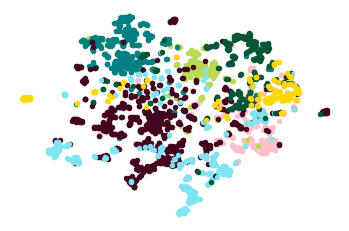

In [15]:
# PLOT 2D OF EMBEDDED REPRESENTATION
@torch.no_grad() # deactivate autograd functionality
def plot_point(colors):
    Node2Vec_model.eval() # evalutae the model based on the trained parameters
    z = Node2Vec_model(torch.arange(data.num_nodes, device=device)) # embedding rep
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure()
    for i in range(dataset.num_classes):
        plt.scatter(z[y==i,0], z[y==i,1],s=20,color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
        '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
        '#ffd700'
    ]
plot_point(colors)



In [ ]:
# NODE CLASSIFICATION